In [2]:
import math
import pickle
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

In [13]:
#
# Execution parameters
#

FILES_PATH="preprocessed_datasets/"
DATASET_NAME="coronavirus_2021q1_all_preprocessed"
BATCH_SIZE=2**14
TRAIN_TEST_METHOD="controlled_subreddits" # random, controlled_users, controlled_subreddits, controlled_both
MODEL_ARCHITECTURE="toxicity_simple" # toxicity_simple, toxicity_NCF, toxicity_BOW

# Grid search parameters
learning_rates=[1e-3,5e-4,1e-4]
n_factors=[16,64,256,1024]
l2_reg=[1e-3,5e-5,0]


epochs=200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
#
# Read dataset and obtain the basic model inputs and outputs
#

df=pd.read_csv(f'{FILES_PATH}/{DATASET_NAME}_preprocessed_toxicity.csv',encoding='UTF_8')

#We roughly defined a (user,subreddit) interaction as toxic when the mean toxicity is >0
df=df.groupby(['author_id','subreddit_id'],as_index=False)['Toxicity'].mean()
df['Toxicity']=df['Toxicity'].apply(lambda x: 0 if x<0 else 1)

print(f"Toxic interactions: {(100*(df['Toxicity'].sum()/len(df['Toxicity']))):.2f}%") #Percentage of toxic interactions (not comments!)

#Primary inputs (author_id, subreddit_id)
x=df.drop(['Toxicity'],axis=1).to_numpy().astype(int)

#Outputs (interaction toxicity)
y=df['Toxicity'].to_numpy()

n_users=df['author_id'].nunique()
n_subreddits=df['subreddit_id'].nunique()

Toxic interactions: 9.35%


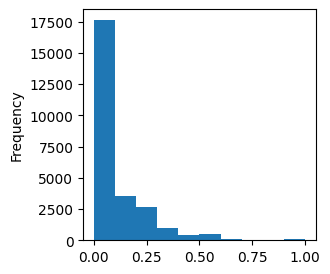

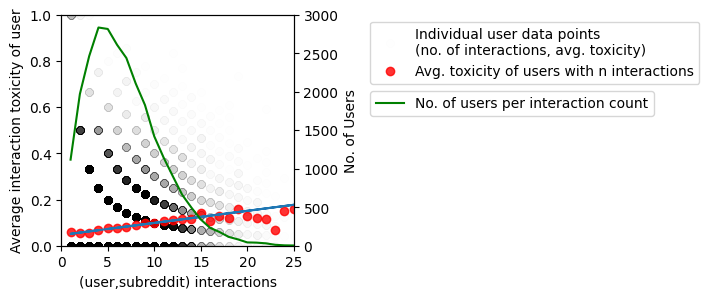

In [15]:
#
# Data analysis and plots
#

plt.rcParams["figure.figsize"]=(3,3)

#Plot histogram of Avg. Toxicity per user
avg_toxicity_per_user=df.groupby(['author_id'],as_index=False)['Toxicity'].mean()
avg_toxicity_per_user['Toxicity'].plot.hist()
plt.show()

#Obtain dataframe with (user_id,comment_count,mean_toxicity)
no_comments_per_user=df.groupby(['author_id'],as_index=False).size()
no_comments_per_user["mean_toxicity"]=avg_toxicity_per_user["Toxicity"]

#** Obtain dataframe with (number_of_comments, avg toxicity for users with number_of_comments)
avg_toxicity_per_interaction_count=no_comments_per_user.groupby(['size'],as_index=False)['mean_toxicity'].mean()

#Obtain dataframe with (number_of_comments, number of users with number_of_comments comments)
no_users_per_comment_count=no_comments_per_user.rename(columns={'size':'comment_count'}).groupby(['comment_count'],as_index=False).size()

#Obtain regression for **
m, b = np.polyfit(no_comments_per_user["size"].to_numpy(), avg_toxicity_per_user['Toxicity'].to_numpy(), 1)

#Plot everything:

#Left y-axis
plt.plot(no_comments_per_user["size"].to_numpy(), avg_toxicity_per_user['Toxicity'].to_numpy(), 'o', alpha=0.005, c='black',label="Individual user data points\n(no. of interactions, avg. toxicity)")
plt.plot(avg_toxicity_per_interaction_count["size"].to_numpy(), avg_toxicity_per_interaction_count['mean_toxicity'].to_numpy(), 'o', alpha=.8, c='red', label="Avg. toxicity of users with n interactions")
plt.plot(no_comments_per_user["size"].to_numpy(), m*no_comments_per_user["size"].to_numpy() + b)

plt.ylim((0,1))
plt.xlim((0,25))

plt.xlabel("(user,subreddit) interactions")
plt.ylabel("Average interaction toxicity of user")

plt.legend(bbox_to_anchor=(1.3, 1), loc="upper left")

#Switch axis
plt.twinx()

#Right y-axis
plt.plot(no_users_per_comment_count["comment_count"].to_numpy(),no_users_per_comment_count["size"].to_numpy(),color='green',label="No. of users per interaction count")

plt.ylim((0,3000))

plt.ylabel("No. of Users")

plt.legend(bbox_to_anchor=(1.3, 0.7), loc="upper left")

plt.show()

In [16]:
#
# Define and perform train/test split, generate datasets
#

def train_test_split(df):
    user_groups=df.groupby('author_id')
    subreddit_groups=df.groupby('subreddit_id')

    test=[]

    # Approach "random": If the user posts in more than 10 subreddits, use them for training set (10% of their interactions)
    if TRAIN_TEST_METHOD=="random":
        for _,group in user_groups:
            if group.shape[0]>=10:
                test+=(group.sample(n=int(group.shape[0]*0.15)).to_dict(orient="records"))

    # Approach "controlled": If they post in more than 10 subreddits AND have a
    elif TRAIN_TEST_METHOD=="controlled_users":
        for _,group in user_groups:
            if group.shape[0]>=10 and group["Toxicity"].sum()>1 and ((group["Toxicity"].shape[0]-group["Toxicity"].sum())>1):
                test += (group[group["Toxicity"]==1].sample(1).to_dict(orient="records"))
                test += (group[group["Toxicity"]==0].sample(1).to_dict(orient="records"))

    elif TRAIN_TEST_METHOD=="controlled_subreddits":
        for _,group in subreddit_groups:
            if group.shape[0]>=10 and group["Toxicity"].sum()>1 and ((group["Toxicity"].shape[0]-group["Toxicity"].sum())>1):
                test += (group[group["Toxicity"]==1].sample(1).to_dict(orient="records"))
                test += (group[group["Toxicity"]==0].sample(1).to_dict(orient="records"))

    elif TRAIN_TEST_METHOD=="controlled_both":
        
        valid_users=[]
        valid_subreddits=[]
        for user,group in user_groups:
            if group.shape[0]>=10 and group["Toxicity"].sum()>2 and ((group["Toxicity"].shape[0]-group["Toxicity"].sum())>2):
                valid_users.append(user)


        for subreddit,group in subreddit_groups:
            if group.shape[0]>=10 and group["Toxicity"].sum()>2 and ((group["Toxicity"].shape[0]-group["Toxicity"].sum())>2):
                valid_subreddits.append(subreddit)
        
        print(f"Found {len(valid_users)} users  and {len(valid_subreddits)} that meet criteria")

        valid_rows = df[(df["author_id"].isin(valid_users)) & (df["subreddit_id"].isin(valid_subreddits))]

        print(f"Intersecting these users and subreddits, {valid_rows['author_id'].nunique()} and {valid_rows['subreddit_id'].nunique()} are preserved")

        test += (valid_rows[valid_rows["Toxicity"]==1].sample(valid_rows["author_id"].nunique()).to_dict(orient="records"))
        test += (valid_rows[valid_rows["Toxicity"]==0].sample(valid_rows["author_id"].nunique()).to_dict(orient="records"))

    test = pd.DataFrame(test)
    print(f"Total test samples: {test.shape[0]}")

    train = pd.concat([df, test]).drop_duplicates(keep=False)
    
    # Unccomment for oversampling toxic interactions in train set
    # train = pd.concat([train,pd.concat([train[train["Toxicity"]==1]]*(round(toxic_labels_weight)-1))])
    
    return train, test

#Split train and test sets

train,test=train_test_split(df) 

toxic_labels_weight=(len(train['Toxicity'])-train['Toxicity'].sum())/train['Toxicity'].sum()
print(f"Applying a weight of {toxic_labels_weight:.2f} for positive samples in training loss")

X_train=train.drop(['Toxicity'],axis=1).to_numpy().astype(int)
X_test=test.drop(['Toxicity'],axis=1).to_numpy().astype(int)

y_train=train['Toxicity'].to_numpy()
y_test=test['Toxicity'].to_numpy()

X_train, X_test = torch.Tensor(X_train).int().to(device), torch.Tensor(X_test).int().to(device)
y_train, y_test = torch.Tensor(y_train).float().to(device), torch.Tensor(y_test).float().to(device)

Total test samples: 576
Applying a weight of 9.85 for positive samples in training loss


In [17]:
#
# Load BOW arrays if using that architecture
#


if MODEL_ARCHITECTURE=="toxicity_BOW":

    #Load users' and subreddits' Bag of Words
    user_bows=pickle.load(open("preprocessed_datasets/coronavirus_2021q1_all_preprocessed_USERS_BAG_OF_WORDS","rb"))
    subreddit_bows=pickle.load(open("preprocessed_datasets/coronavirus_2021q1_all_preprocessed_SUBREDDIT_BAG_OF_WORDS","rb"))

    #We're gonna work with binary vectors for now
    user_bows[user_bows>1]=1
    subreddit_bows[subreddit_bows>1]=1

    user_bows=torch.Tensor(user_bows).float().to(device)
    subreddit_bows=torch.Tensor(subreddit_bows).float().to(device)


In [18]:
#
# Define the model architecture
#

class ToxicitySimple(nn.Module):
    def __init__(self,d):
        super(ToxicitySimple,self).__init__()

        #We only have one trainable layer depth (two Embeddings and two FC's)

        self.u = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.m = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors
        # self.u1 = nn.Linear(user_bows.shape[1],n_factors)       #FC        author bow -> n_factors
        # self.m1 = nn.Linear(subreddit_bows.shape[1],n_factors)  #FC        subreddit bow -> n_factors

        #Initialize weights
        self.u.weight.data.uniform_(-0.1, 0.1)
        self.m.weight.data.uniform_(-0.1, 0.1)
        # self.u1.weight.data.uniform_(-0.05, 0.05)
        # self.m1.weight.data.uniform_(-0.05, 0.05)

    def forward(self, x):
        users, subreddits = x[:,0] , x[:,1] #Get author_id and subreddit_id from input
        # ubows, sbows = user_bows[x[:,0].long()], subreddit_bows[x[:, 1].long()] #Get author bow and subreddit bow indirectly from input
        u,m = self.u(users), self.m(subreddits) #Embed author and subreddit
        # u,m = self.u1(u), self.m1(m)
        # u1, m1 = self.u1(ubows), self.m1(sbows) #Reduce dimensionality of author bow and subreddit bow
        
        #Concat u with u1, and m with m1. Compute the dot product of the resulting vectors, and pass the value through a sigmoid.

        #If using the model with BOW and BCE
        # return torch.sigmoid((torch.cat((u, u1), 1) * torch.cat((m, m1), 1)).sum(1).view(-1, 1)) #Sigmoid

        #If using simple model and BCE
        # return torch.sigmoid((u*m).sum(1).view(-1, 1))

        #For simple model and BCEwithLogits
        return (u*m).sum(1).view(-1, 1)

#References: https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96
class ToxicityNCF(nn.Module):
    def __init__(self,d):
        super(ToxicityNCF,self).__init__()

        #We only have one trainable layer depth (two Embeddings and two FC's)
        self.u_mf = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.u_mlp = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.m_mf = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors
        self.m_mlp = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors

        #Initialize weights
        self.u_mf.weight.data.uniform_(-0.5, 0.5)
        self.u_mlp.weight.data.uniform_(-0.5, 0.5)

        self.m_mf.weight.data.uniform_(-0.5, 0.5)
        self.m_mlp.weight.data.uniform_(-0.5, 0.5)

        self.fc_mf_1 = nn.Linear(d,d//2)
        self.fc_mf_2 = nn.Linear(d//2,d//4)

        self.fc_mf_1.weight.data.uniform_(-0.5, 0.5)
        self.fc_mf_2.weight.data.uniform_(-0.5, 0.5)

        self.fc_mlp_1 = nn.Linear(d*2,d)
        self.fc_mlp_2 = nn.Linear(d,d//2)
        self.fc_mlp_3 = nn.Linear(d//2,d//4)

        self.fc_mlp_1.weight.data.uniform_(-0.5, 0.5)
        self.fc_mlp_2.weight.data.uniform_(-0.5, 0.5)
        self.fc_mlp_3.weight.data.uniform_(-0.5, 0.5)

        self.neumf = nn.Linear(d//2,1)
        self.neumf.weight.data.uniform_(-0.5, 0.5)

        self.dropout=nn.Dropout(0.1)

    def forward(self, x):
        
        users, subreddits = x[:,0] , x[:,1] #Get author_id and subreddit_id from input
        # ubows, sbows = user_bows[x[:,0].long()], subreddit_bows[x[:, 1].long()] #Get author bow and subreddit bow indirectly from input
        u_mf, m_mf = self.u_mf(users), self.m_mf(subreddits) #Embed author and subreddit

        u_mlp, m_mlp = self.u_mlp(users), self.m_mlp(subreddits)

        mf = self.dropout(nn.functional.relu(self.fc_mf_1(u_mf*m_mf)))
        mf = self.dropout(nn.functional.relu(self.fc_mf_2(mf)))

        mlp = self.dropout(nn.functional.relu(self.fc_mlp_1(torch.cat((u_mlp,m_mlp),1))))
        mlp = self.dropout(nn.functional.relu(self.fc_mlp_2(mlp)))
        mlp = self.dropout(nn.functional.relu(self.fc_mlp_3(mlp)))

        neumf = self.neumf(torch.cat((mf,mlp),1))

        return neumf

class ToxicityBOW(nn.Module):
    def __init__(self,d):
        super(ToxicityBOW,self).__init__()

        #We only have one trainable layer depth (two Embeddings and two FC's)

        self.u = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.m = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors
        self.u1 = nn.Linear(user_bows.shape[1],d)       #FC        author bow -> n_factors
        self.m1 = nn.Linear(subreddit_bows.shape[1],d)  #FC        subreddit bow -> n_factors

        #Initialize weights
        self.u.weight.data.uniform_(-0.1, 0.1)
        self.m.weight.data.uniform_(-0.1, 0.1)
        self.u1.weight.data.uniform_(-0.1, 0.1)
        self.m1.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x):
        users, subreddits = x[:,0] , x[:,1] #Get author_id and subreddit_id from input
        ubows, sbows = user_bows[x[:,0].long()], subreddit_bows[x[:, 1].long()] #Get author bow and subreddit bow indirectly from input
        u,m = self.u(users), self.m(subreddits) #Embed author and subreddit
        u1, m1 = self.u1(ubows), self.m1(sbows) #Reduce dimensionality of author bow and subreddit bow
        
        #Concat u with u1, and m with m1. Compute the dot product of the resulting vectors, and pass the value through a sigmoid.

        #If using the model with BOW and BCE
        return (torch.cat((u, u1), 1) * torch.cat((m, m1), 1)).sum(1).view(-1, 1) 


In [28]:
#
# Create the Dataset and Dataloader objects for train and test sets
#

class ToxicityDataset(Dataset):
    def __init__(self):
        self.x=X_train
        self.y=y_train
        self.n_samples=X_train.size(0)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples

class TestDataset(Dataset):
    def __init__(self):
        self.x=X_test
        self.y=y_test
        self.n_samples=X_test.size(0)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples

train_data=ToxicityDataset()
dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

test_data=TestDataset()
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)

print(f"Toxic interactions (positive samples) in train test: {np.average(y_train.cpu())*100:.2f}%")
print(f"Toxic interactions (positive samples) in test test: {np.average(y_test.cpu())*100:.2f}%")


Toxic interactions (positive samples) in train test: 9.22%
Toxic interactions (positive samples) in test test: 50.00%


In [46]:
#
# Define the training cycle for the model
#
print(f"CUDA availability: {torch.cuda.is_available()}")
print(f"Using pytorch version {torch.__version__}, {torch.version.cuda}")
def train_toxicity_model(n_factors=64,learning_rate=1e-3,l2_reg=1e-5,epochs=10):
    print(f"Current parameters are d:{n_factors} | L.Rate:{learning_rate} | L2 Reg:{l2_reg}")
    
    losses=[]
    losses_test=[]
    accuracies=[]
    accuracies_test=[]
    TPRs=[]
    TPRs_test=[]
    
    Iterations=[]

    #Initialize model
    if MODEL_ARCHITECTURE=="toxicity_simple":
        model = ToxicitySimple(n_factors).to(device)
    elif MODEL_ARCHITECTURE=="toxicity_NCF":
        model = ToxicityNCF(n_factors).to(device)
    elif MODEL_ARCHITECTURE=="toxicity_BOW":
        model = ToxicityBOW(n_factors).to(device)
    
    #Model configuration
    optimizer=torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2_reg) #Weight_decay acts as L2 regularization apparently

    print("EPOCH\tLOSS_TRAIN\tLOSS_TEST\tACC_TRAIN\tACC_TEST\tTP\tFP\tFN\tTN\tTPR_TRAIN\tTPR_TEST")
    # for epoch in tqdm(range(int(epochs)), desc='Training Epochs'):
    for epoch in range(int(epochs)):

        model.train()

        loss_train=0
        
        fn=0
        fp=0
        tn=0
        tp=0

        #Iterate training over train batches
        for i,(inputs,labels) in enumerate(dataloader):
            optimizer.zero_grad()  # Setting our stored gradients equal to zero

            outputs = torch.squeeze(model(inputs))

            #References: https://stackoverflow.com/questions/71462326/pytorch-bcewithlogitsloss-calculating-pos-weight
            # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586 (apparently more numerically stable than BCELoss)
            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([toxic_labels_weight]).to(device))

            loss = criterion(outputs, labels)

            loss_train += loss.item()*inputs.size(0)

            loss.backward()  # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step()  # Updates weights and biases with the optimizer (Adam)

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293
            predicted_train = ((outputs.cpu() > 0.0)).float().detach().numpy()
            
            labels_train = labels.detach().cpu().numpy()


            tp += np.sum(np.logical_and(predicted_train,labels_train))
            tn += np.sum(np.logical_and(np.logical_not(predicted_train),np.logical_not(labels_train)))
            fn += np.sum(np.logical_and(np.logical_not(predicted_train),labels_train))
            fp += np.sum(np.logical_and(predicted_train,np.logical_not(labels_train)))

        TPRs.append(100*tp/(tp+fn))
                
        accuracy = 100 * (tp+tn) / y_train.size(0)
        
        loss_train = loss_train/y_train.size(0)
            
        losses.append(loss_train)
        accuracies.append(accuracy)
    
           
        with torch.no_grad():
            # Compute metrics for test dataset
            model.eval()
            loss_test=0

            fn=0
            fp=0
            tn=0
            tp=0

            for j, (test_inputs, test_labels) in enumerate(test_dataloader):
                
                outputs_test = torch.squeeze(model(test_inputs))

                if TRAIN_TEST_METHOD=="random":
                    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([toxic_labels_weight]).to(device))
                elif TRAIN_TEST_METHOD in ["controlled_users","controlled_subreddits","controlled_both"]:
                    criterion = torch.nn.BCEWithLogitsLoss()

                loss_test += criterion(outputs_test, test_labels).item()*test_inputs.size(0)

                predicted_test = ((outputs_test.cpu() > 0.0)).detach().numpy()

                labels_test = test_labels.detach().cpu().numpy()

                tp += np.sum(np.logical_and(predicted_test,labels_test))
                tn += np.sum(np.logical_and(np.logical_not(predicted_test),np.logical_not(labels_test)))
                fn += np.sum(np.logical_and(np.logical_not(predicted_test),labels_test))
                fp += np.sum(np.logical_and(predicted_test,np.logical_not(labels_test)))

            accuracy_test = 100 * (tn+tp) / y_test.size(0)

            loss_test = loss_test/y_test.size(0)

            losses_test.append(loss_test)
            accuracies_test.append(accuracy_test)

            # Calculating the loss and accuracy for the train dataset.

            Iterations.append(iter)

            TPRs_test.append(100*tp/(tp+fn))

            # avg_1_train=np.average(torch.squeeze(outputs).cpu()[np.where(labels_train==1)])
            # avg_1_test=np.average(outputs_test[np.where(labels_test==1)])
            
            print(f"{epoch}\t{loss_train:.7f}\t{loss_test:.7f}\t{accuracy:.2f}\t\t{accuracy_test:.2f}\t\t{tp}\t{fp}\t{fn}\t{tn}\t{TPRs[-1]:.2f}\t\t{TPRs_test[-1]:.2f}",end="\r")
    
    print(f"{epoch}\t{loss_train:.7f}\t{loss_test:.7f}\t{accuracy:.2f}\t\t{accuracy_test:.2f}\t\t{tp}\t{fp}\t{fn}\t{tn}\t{TPRs[-1]:.2f}\t{TPRs_test[-1]:.2f}")
    return losses,losses_test,accuracies,accuracies_test, TPRs, TPRs_test



CUDA availability: True
Using pytorch version 1.12.1+cu113, 11.3


Current parameters are d:16 | L.Rate:0.001 | L2 Reg:0.001
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	1.2410527	0.6931297	82.47		51.56		70	61	218	227	41.10	24.3119
Current parameters are d:16 | L.Rate:0.001 | L2 Reg:5e-05
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.3412144	0.7540867	96.49		52.26		54	41	234	247	99.89	18.7551
Current parameters are d:16 | L.Rate:0.001 | L2 Reg:0
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.0768556	1.5311472	98.69		52.08		55	43	233	245	100.00	19.100
Current parameters are d:16 | L.Rate:0.0005 | L2 Reg:0.001
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	1.2455668	0.6931375	82.38		53.82		74	52	214	236	42.95	25.6999
Current parameters are d:16 | L.Rate:0.0005 | L2 Reg:5e-05
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.5164663	0.7144654	91.14		54.34		80	55	208	233	99.81	27.78

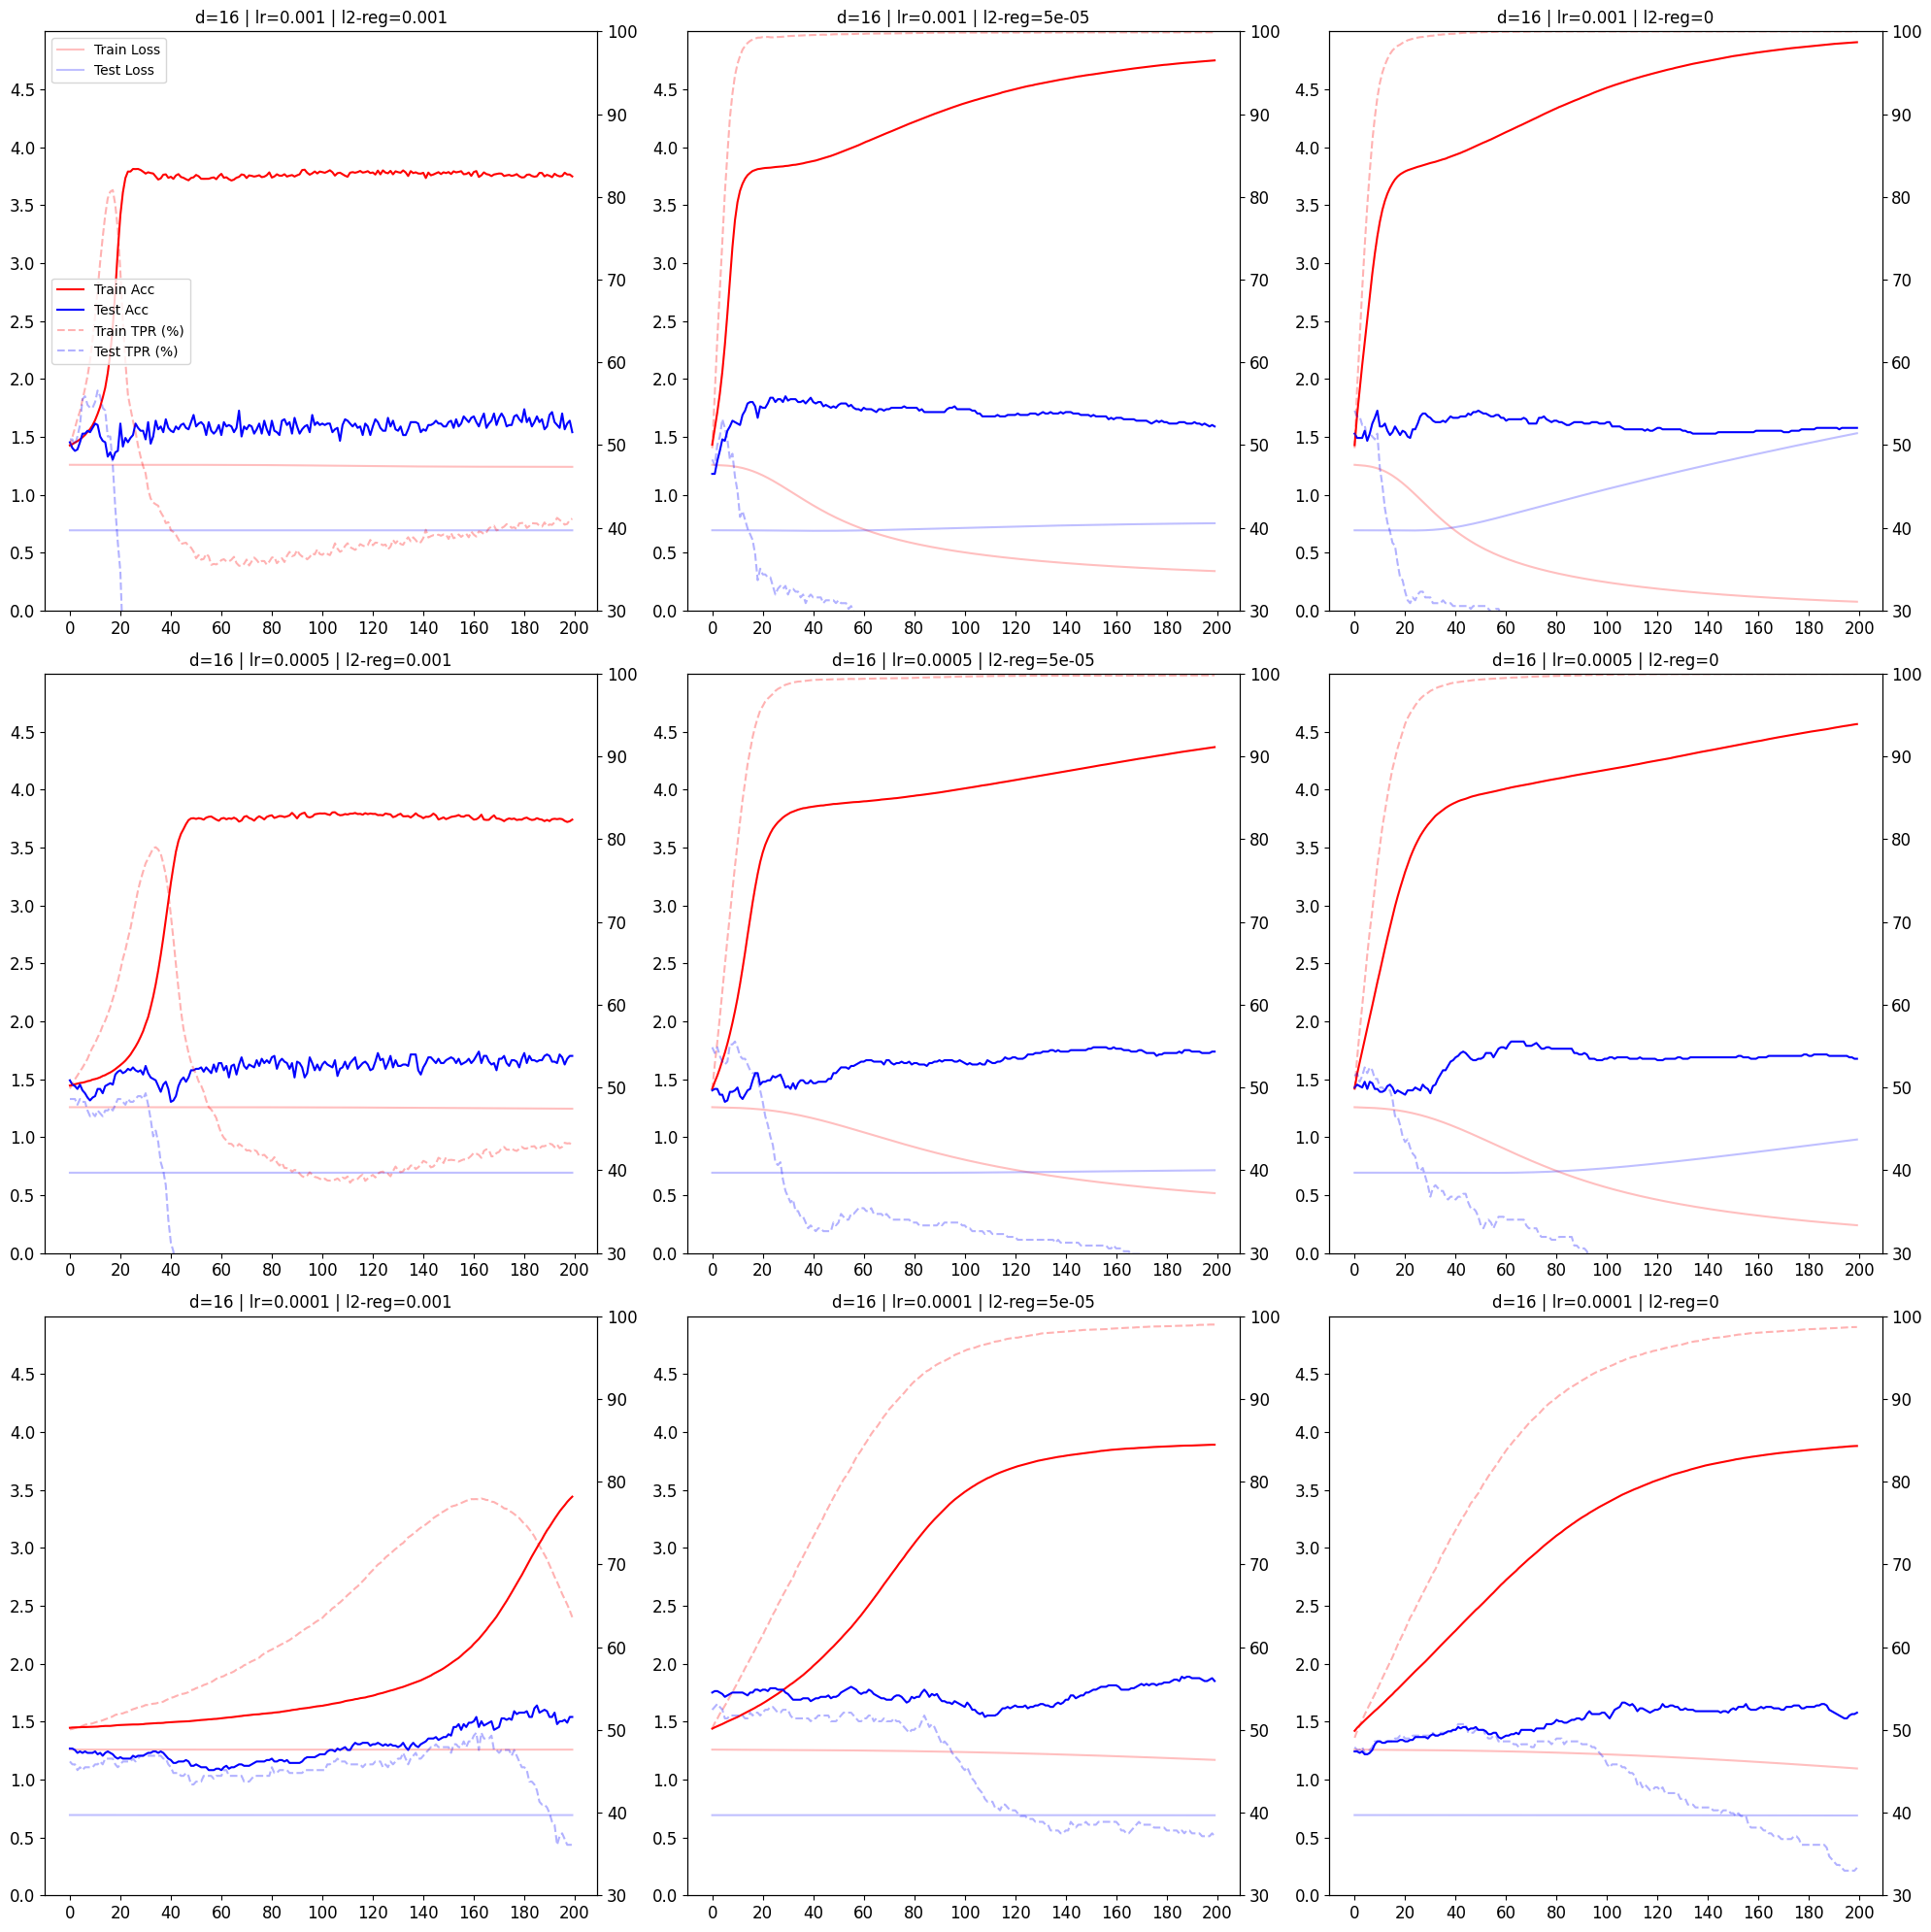

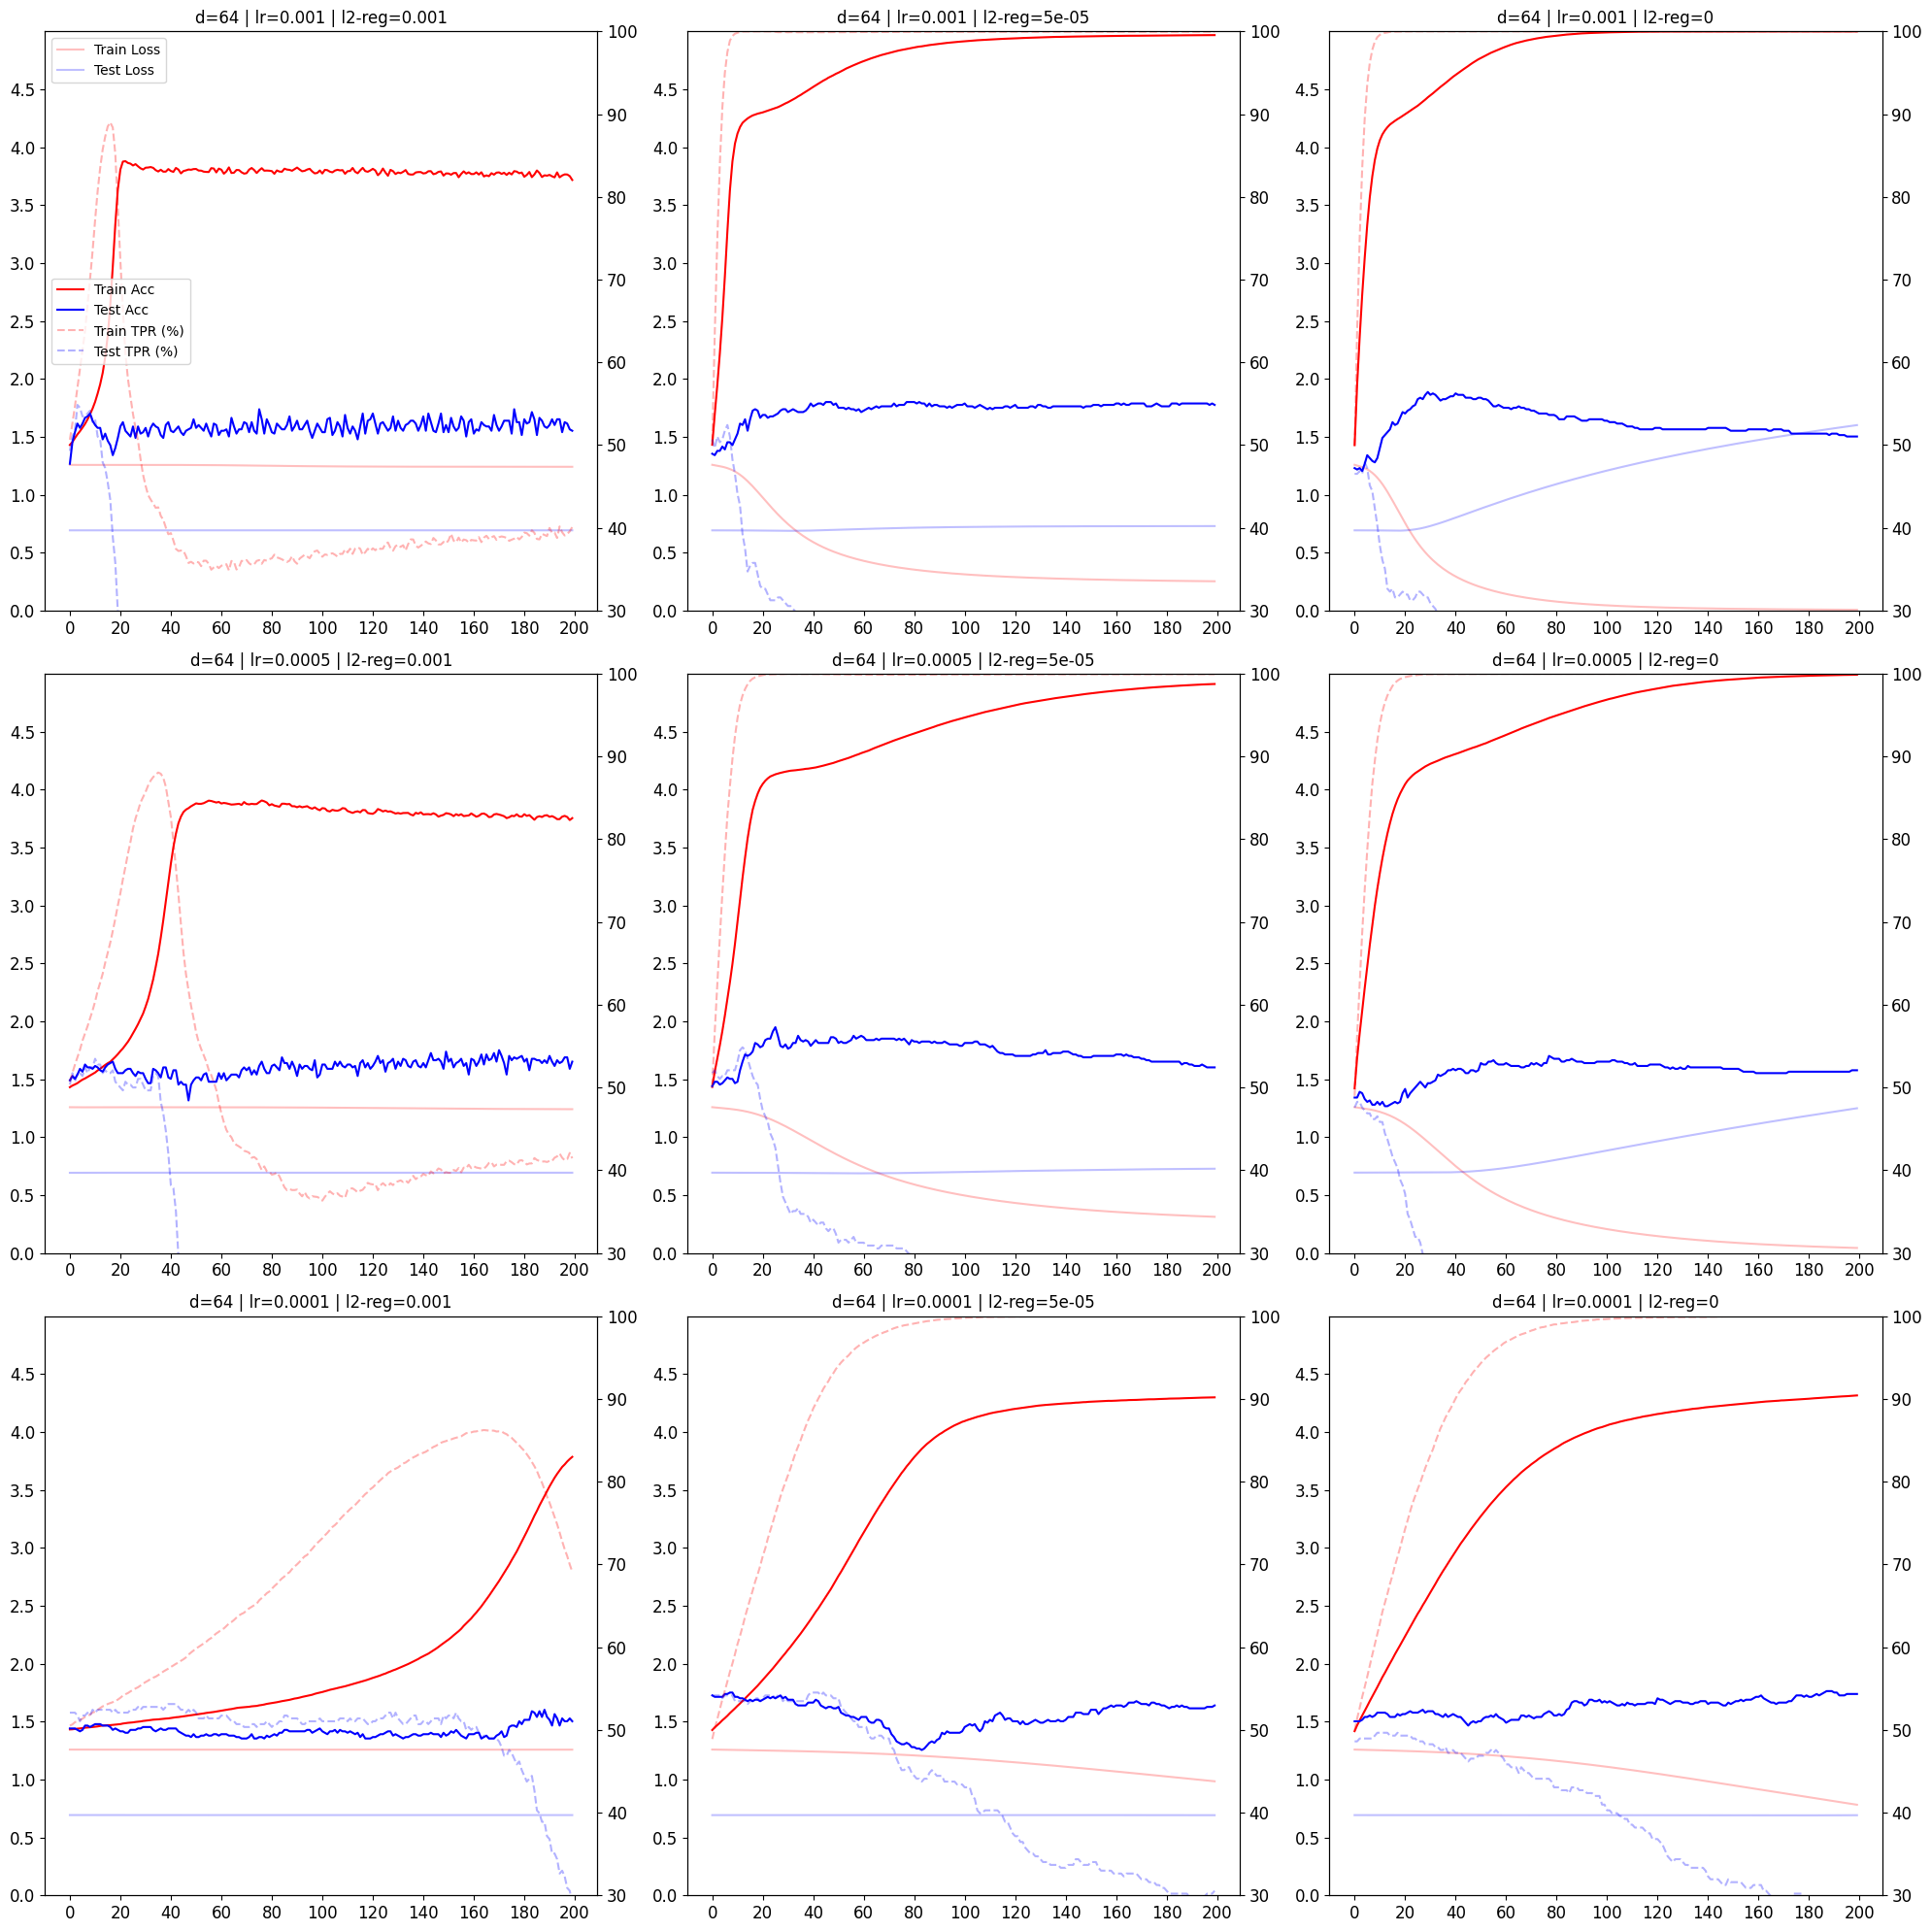

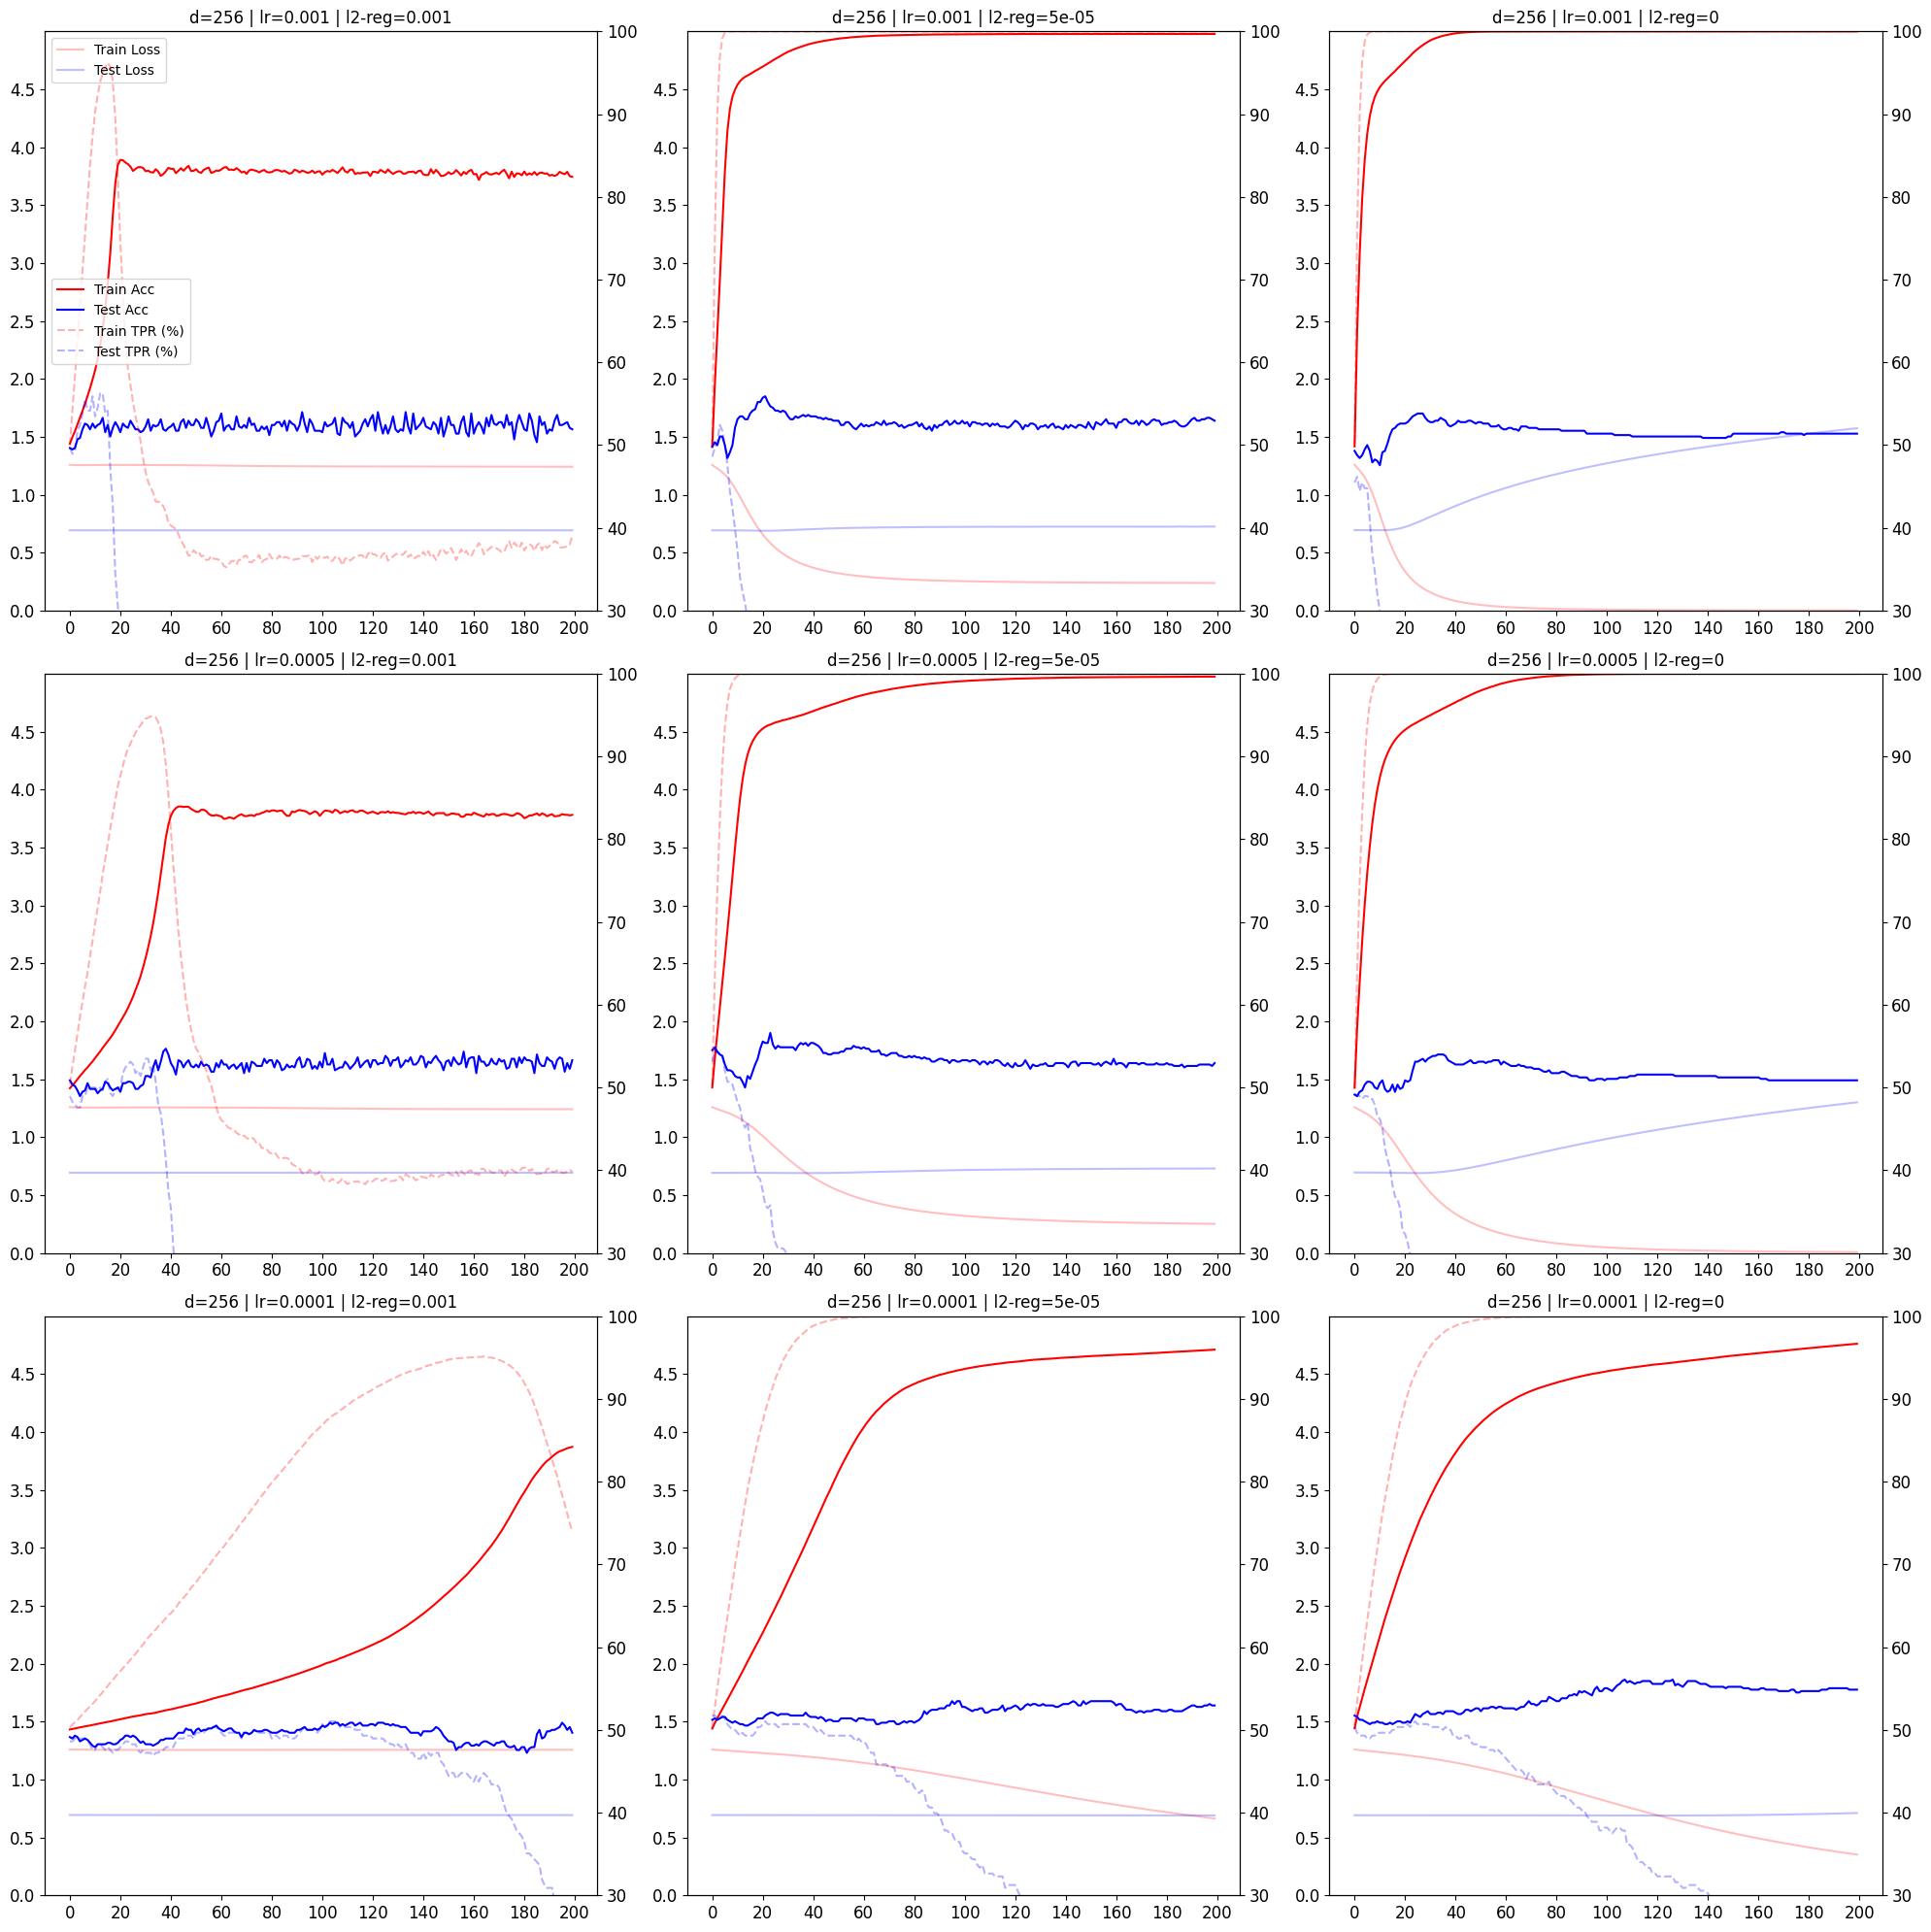

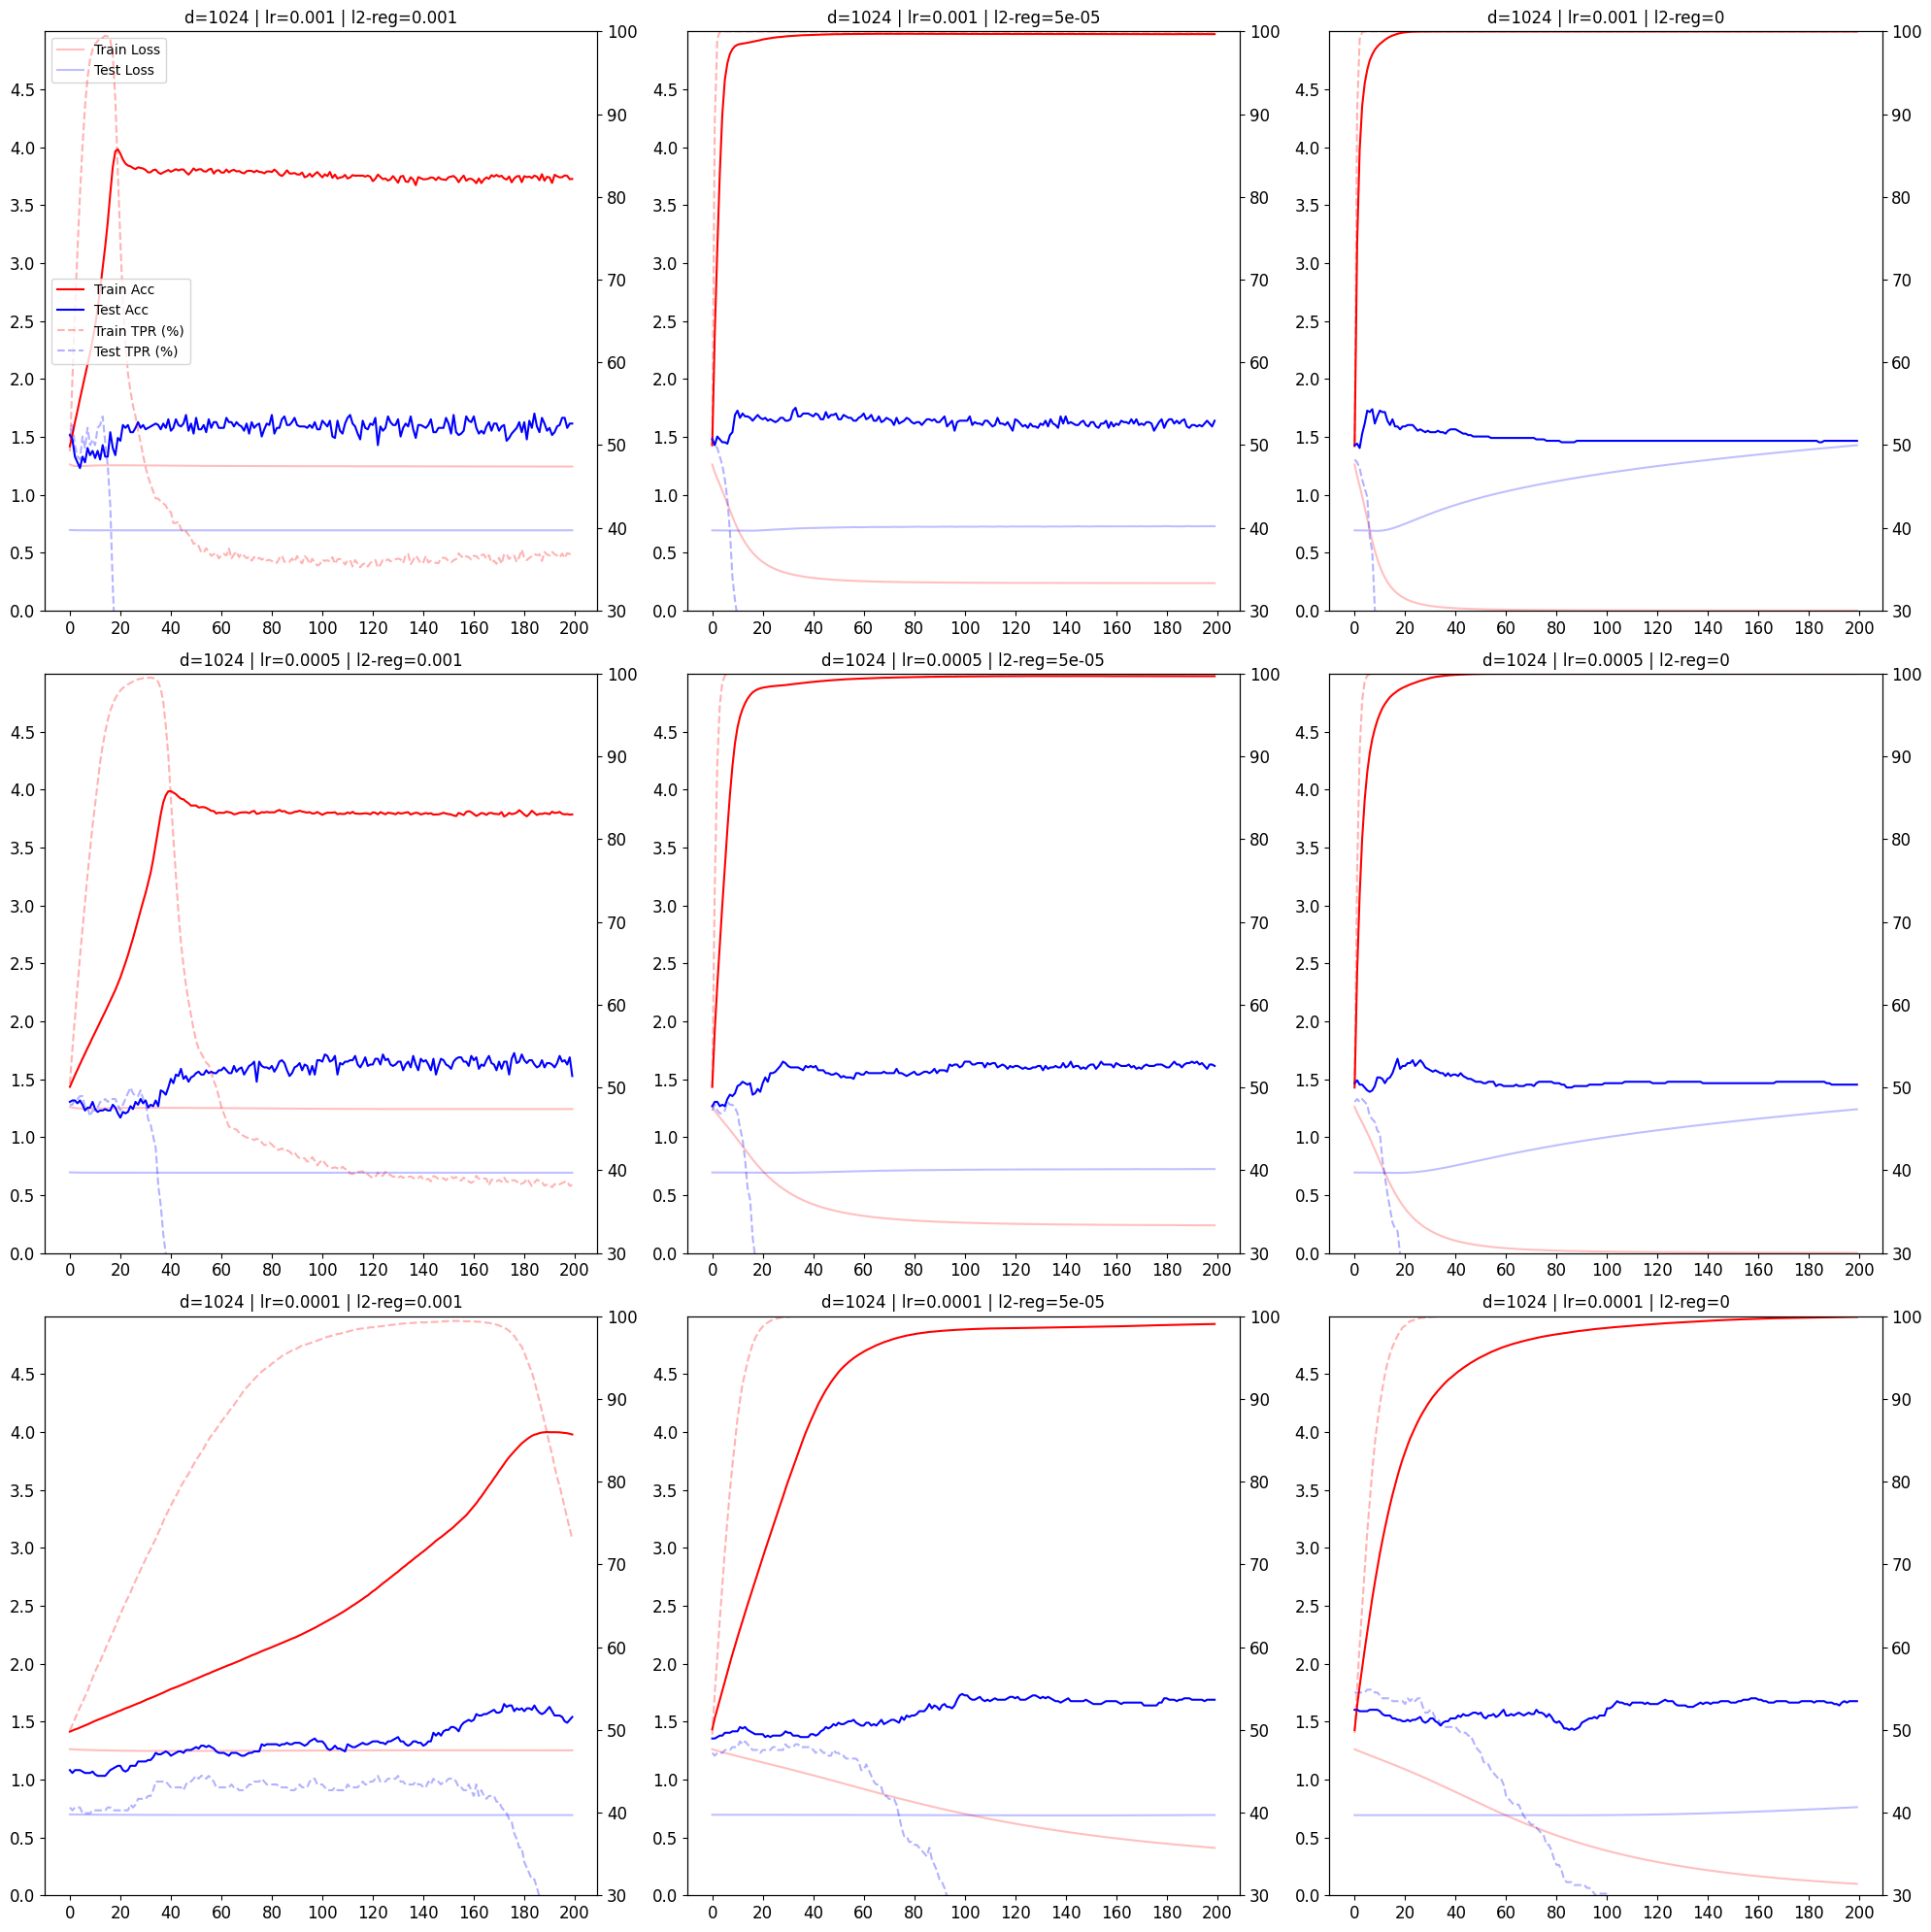

In [47]:
#
# Perform grid search
#

# Figures are saved in pdf format in a folder specific to configuration. One figure is created 
# per each *d* used, with one subfigure per each (lr, L2 reg) combination
directory_path = f"grid_search/{MODEL_ARCHITECTURE}_split{TRAIN_TEST_METHOD}_e{epochs}"
os.makedirs(directory_path,exist_ok=True)

for d in n_factors:
    i=1

    plt.figure(figsize=(20,(20*min(len(learning_rates),len(l2_reg)))/max(len(learning_rates),len(l2_reg))))

    for lr in learning_rates:
        for reg in l2_reg:
            losses,losses_test,accuracies,accuracies_test,TPRs,TPRs_test = train_toxicity_model(n_factors=d,learning_rate=lr,l2_reg=reg,epochs=epochs)

            #Plot current training interation:
            plt.subplot(len(learning_rates),len(l2_reg),i)
            plt.title(f"d={d} | lr={lr} | l2-reg={reg}",fontdict={'fontsize': 12})

            plt.xticks(np.arange(0,epochs+1,20),fontsize=12)
            plt.yticks(np.arange(0,5,0.5),fontsize=12)

            plt.ylim(0,5)
            
            plt.plot(np.arange(0,epochs,1),losses, color="red",alpha=.25,label="Train Loss") #Train loss evolution
            plt.plot(np.arange(0,epochs,1),losses_test, color="blue",alpha=.25,label="Test Loss") #Test loss evolution

            if i==1: plt.legend(loc="upper left")

            plt.twinx() #Swap axis

            plt.yticks(np.arange(30,101,10),fontsize=12)

            plt.ylim(30,100)

            plt.plot(np.arange(0,epochs,1),accuracies, color="red", label="Train Acc")         #Train acc evolution
            plt.plot(np.arange(0,epochs,1),accuracies_test, color="blue", label="Test Acc")   #Test acc evolution

            plt.plot(np.arange(0,epochs,1),TPRs, '--', color="red", label="Train TPR (%)" , alpha=.3)   # Train TPR (%) evolution
            plt.plot(np.arange(0,epochs,1),TPRs_test, '--', color="blue", label="Test TPR (%)", alpha=.3)   #Test TPR (%) evolution

            if i==1: plt.legend(loc="center left")
            i+=1

    plt.tight_layout()
    plt.savefig(f"{directory_path}/d_{d}.pdf")